**All Required Import's**

In [32]:
import os
from google.colab import drive

import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

import numpy as np

#  **(step 1):  Data Collection & Preprocessing**

---



**I) Get Dataset From Drive**





In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


**[#] Constant Variables**

In [35]:
MODEL_NAME = "PCDC"
IMAGE_SIZE = 256      # 256 * 256 image
BATCH_SIZE = 32       # 32 image per batch
CHANNELS = 3          # 3 for rgb
EPOCHS = 50           # number of EPOCHS

**II) Generate tf.Dataset from local dataset**

In [4]:
# Generate dataset by tensorflow input data pipline
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Datasets/PotatoCropDiseaseClassification_ds",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE 
)

Found 2156 files belonging to 3 classes.


**[#] Check the dataset**

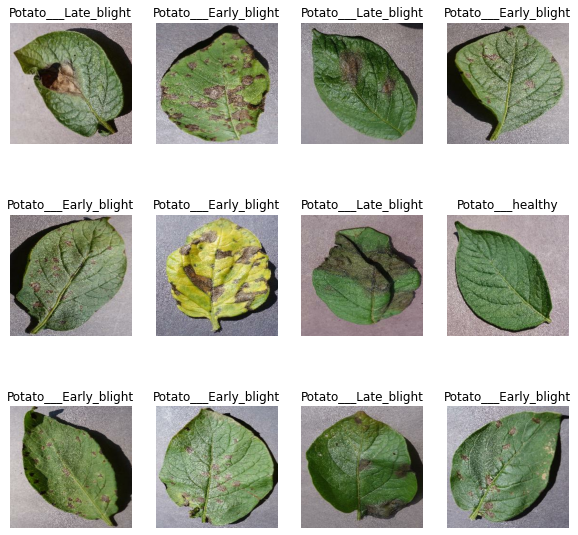

In [5]:
# get the class names
class_names = dataset.class_names

# increase the output image area
plt.figure(figsize=(10, 10))

# image_batch, label_batch are tensors
# to use image_batch, label_batch we need to convert
# them to numpy using .numpy() method
# to use numpy version in matplotlib we have to convert
# those from type: float to type:int by astype("uint8")
for image_batch, label_batch in dataset.take(1):
    for idx in range(1, 13):
        ax = plt.subplot(3, 4, idx)
        plt.imshow(image_batch[idx].numpy().astype("uint8"))
        plt.title(class_names[label_batch[idx]])
        plt.axis("off")

**[#] Function for spliting dataset into training, testing and validating datasets**

In [6]:
def get_tf_dataset_partitions(ds, train_split=0.8, val_split=0.1, 
                              test_spilt=0.1, shuffle=True, shuffle_size=10000):
    """
    This function takes the tf.Datasetand returns 3 datasets by spliting it by 
    train_split, val_split and test_spilt values .
    """
    ds_size = len(ds)

    # if shuffle is True than shuffles the ds using shuffle_size and 
    # seed value 12.
    if shuffle:
      ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(ds_size * train_split)
    val_size = int(ds_size * val_split)
    test_size = int(ds_size * test_spilt)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).take(test_size)

    return train_ds, val_ds, test_ds

**III) Get train, test, validate datasets**

In [7]:
# get training, validating and testing data
train_ds, val_ds, test_ds = get_tf_dataset_partitions(dataset)

# cacheing the dataset to improve performance
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

IV) Scaling and resizing

In [8]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

**V) Data augmentation for robust model**

In [9]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

**[#] Applying Data Augmentation to Train Dataset**

In [18]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

# **(setp 2): Model Building & Training**
---



**I) Build Model with the best architecture for the problem**

In [17]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

# CNN is best for'image classification problem'.
# In model building :
# 1) adding preprocessing layers
# 2) defining CNN & MaxPooling layers several times
# 3) have to flatten inorder get 1d array from 2d array
# 4) adding dense layer
model = models.Sequential([
    # preprocessing layers
    resize_and_rescale,
    # CNN & MaxPooling layers
    layers.Conv2D(32, kernel_size = (3,3), activation='relu',
                  input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    # flatten layer
    layers.Flatten(),
    # Dense layer
    layers.Dense(64, activation='relu'),
    # softmax function will normalize the probality of the classes
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

**[#] check model summary**

In [19]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d_18 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (32, 60, 60, 64)         

**II) Model compile**

In [20]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

**III) fit/feed the model with data (traing start's)**

In [22]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 [==============================] - 344s 4s/step - loss: 0.9057 - accuracy: 0.5249 - val_loss: 0.8924 - val_accuracy: 0.5156
Epoch 2/50
54/54 [==============================] - 196s 4s/step - loss: 0.5753 - accuracy: 0.7610 - val_loss: 0.3697 - val_accuracy: 0.8333
Epoch 3/50
54/54 [==============================] - 195s 4s/step - loss: 0.2683 - accuracy: 0.9016 - val_loss: 0.3745 - val_accuracy: 0.8333
Epoch 4/50
54/54 [==============================] - 194s 4s/step - loss: 0.1880 - accuracy: 0.9201 - val_loss: 0.2894 - val_accuracy: 0.8854
Epoch 5/50
54/54 [==============================] - 193s 4s/step - loss: 0.2232 - accuracy: 0.9172 - val_loss: 0.1096 - val_accuracy: 0.9635
Epoch 6/50
54/54 [==============================] - 194s 4s/step - loss: 0.1093 - accuracy: 0.9560 - val_loss: 0.3578 - val_accuracy: 0.8802
Epoch 7/50
54/54 [==============================] - 194s 4s/step - loss: 0.1950 - accuracy: 0.9282 - val_loss: 0.1043 - val_accuracy: 0.9740
Epoch 8/50
54

**[#] Check model accuracy and performance**

In [39]:
scores = model.evaluate(test_ds)

6/6 [==============================] - 6s 832ms/step - loss: 0.0245 - accuracy: 0.9948


# **(step 3) Visualize & Analyze Model Trainig Data**

---



**I) get data for Plotting**

In [24]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

**II) Visualize data for Analyze**

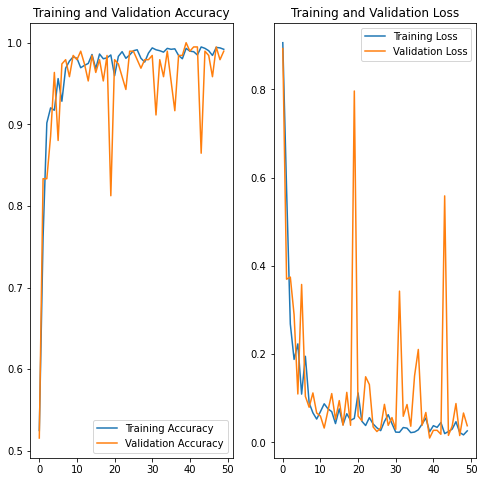

In [38]:
plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), accuracy, label='Training Accuracy')
plt.plot(range(EPOCHS), val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

# **(step 4) Run Test & Save The Model**

---



**I) write a predict function**

In [28]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img.numpy())
    img_array = tf.expand_dims(img_array, 0)          # create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)

    return predicted_class, confidence

**II) Run test on model**

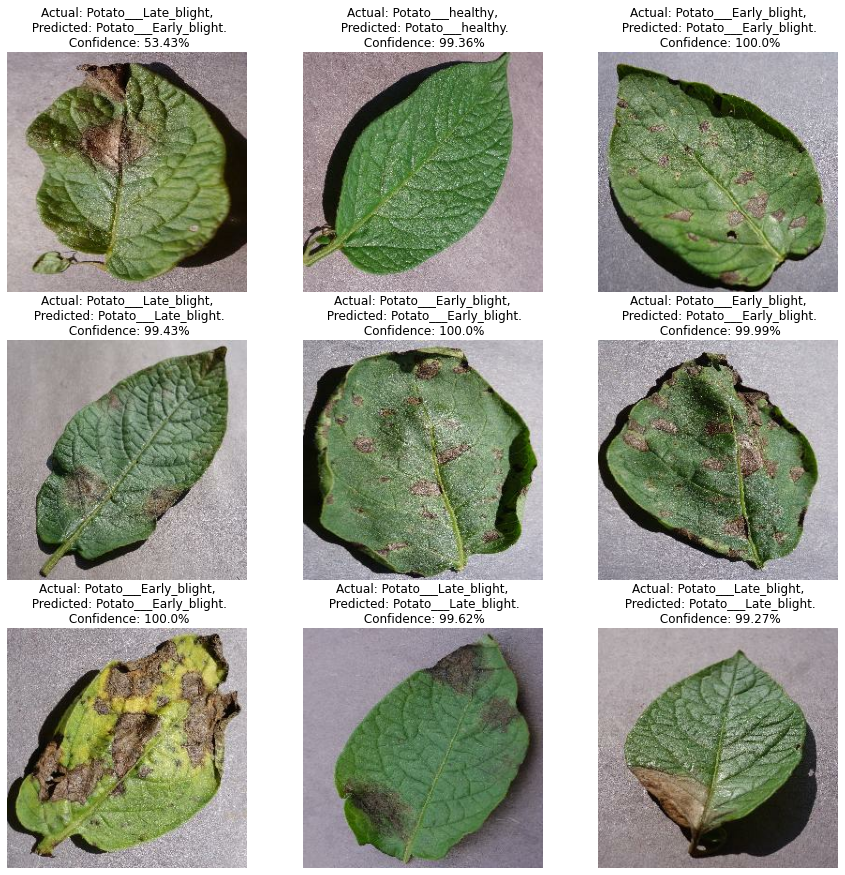

In [37]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

**III) save the model**

In [36]:
model_version=max(
    [int(i) for i in os.listdir(f"/content/drive/MyDrive/TF_MODELS/{MODEL_NAME.lower()}") + [0]]
    )+1
model.save(f"/content/drive/MyDrive/TF_MODELS/{MODEL_NAME.lower()}/{MODEL_NAME}_{model_version}")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/TF_MODELS/pcdc/PCDC_1/assets
